In [79]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tqdm
import glob
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf


from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Nadam
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

%matplotlib inline

In [ ]:
#Data Arugment
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

#test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [ ]:
train_batch_size = 256
val_batch_size = 32
img_shape = (224, 224, 3)
train_generator = train_datagen.flow_from_directory(
            '/content/gdrive/MyDrive/FINAL/TrashData/Train',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = train_batch_size,
            class_mode = 'categorical',)

Found 2923 images belonging to 6 classes.


In [ ]:
validation_generator = valid_datagen.flow_from_directory(
            '/content/gdrive/MyDrive/FINAL/TrashData/Valid',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False)

Found 60 images belonging to 6 classes.


In [ ]:
vgg = VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = img_shape)

In [ ]:

# Freeze the layers except the last 3 layers
for layer in vgg.layers[:-3]:
    layer.trainable = False

In [ ]:
# Summary

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Defining Layers

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# Train Model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
# Train the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=14)
mc = ModelCheckpoint('VGG16 Garbage Classifier.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    verbose=0,
    callbacks = [es, mc],)

<ipython-input-46-3f6a687306aa>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



Epoch 1: val_acc improved from -inf to 0.46667, saving model to VGG16 Garbage Classifier.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_acc improved from 0.46667 to 0.58333, saving model to VGG16 Garbage Classifier.h5

Epoch 3: val_acc improved from 0.58333 to 0.78333, saving model to VGG16 Garbage Classifier.h5

Epoch 4: val_acc improved from 0.78333 to 0.85000, saving model to VGG16 Garbage Classifier.h5

Epoch 5: val_acc did not improve from 0.85000

Epoch 6: val_acc improved from 0.85000 to 0.90000, saving model to VGG16 Garbage Classifier.h5

Epoch 7: val_acc did not improve from 0.90000

Epoch 8: val_acc did not improve from 0.90000

Epoch 9: val_acc did not improve from 0.90000

Epoch 10: val_acc improved from 0.90000 to 0.91667, saving model to VGG16 Garbage Classifier.h5

Epoch 11: val_acc improved from 0.91667 to 0.93333, saving model to VGG16 Garbage Classifier.h5

Epoch 12: val_acc did not improve from 0.93333

Epoch 13: val_acc did not improve from 0.93333

Epoch 14: val_acc did not improve from 0.93333

Epoch 15: val_acc did not improve from 0.93333

Epoch 16: val_acc did not improve from 0.

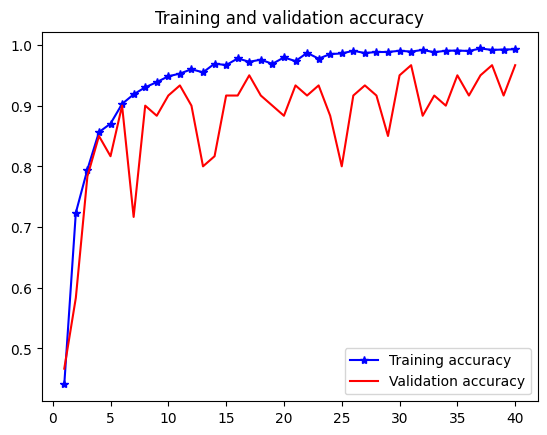

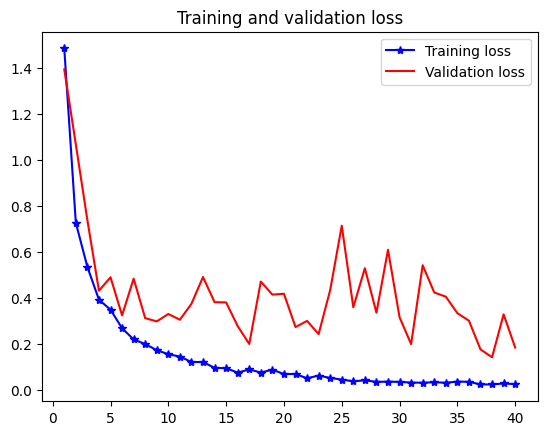

In [ ]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test

In [92]:
model_pre = tf.keras.models.load_model('/content/VGG16 Garbage Classifier.h5')

In [93]:
def predict_image(path):
  img = cv2.imread (path)
  img_ = cv2.resize(img,(224,224))
  img_ = np.reshape(img_,[1,224,224,3])
  img_ = img_/225
  pred = model_pre.predict(img_)
  return pred,img

1/1 [==============================] - 0s 330ms/step
plastic


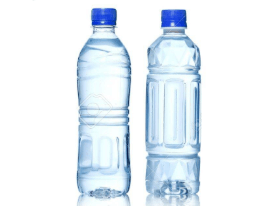

In [94]:
#Show Result
pred,img=predict_image('/content/chai-nhua-1.png')
max_idx = np.argmax(pred)
class_indices = {v:k for k,v in train_generator.class_indices.items()}
print(class_indices[max_idx])
cv2_imshow(img)
